In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
first_year = 1961
last_year = 2100

T_month = np.zeros(((last_year-first_year+1),12,91,139))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year == 1985 or year == 2071:
        continue
    if year <2015:
        ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    else:
        ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    
    T_month[year-1961]=ds_T.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [4]:
T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.1985.nc')

T_month[1985-1961] = T.TTz.isel(ztqlev=0).groupby("time.month").mean("time")[:,jmin:jmax,imin:imax]

T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.2071.nc')

T_month[2071-1961] = T.TTz.isel(ztqlev=0).groupby("time.month").mean("time")[:,jmin:jmax,imin:imax]

In [5]:
ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/monthly/MON.EC-Earth3_HIST.EUe.TTz.2000.nc')

ds_T.time

<xarray.DataArray 'time' (time: 12)>
array(['2000-01-16T12:00:00.000000000', '2000-02-15T12:00:00.000000000',
       '2000-03-16T12:00:00.000000000', '2000-04-16T00:00:00.000000000',
       '2000-05-16T12:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2000-07-16T12:00:00.000000000', '2000-08-16T12:00:00.000000000',
       '2000-09-16T00:00:00.000000000', '2000-10-16T12:00:00.000000000',
       '2000-11-16T00:00:00.000000000', '2000-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [6]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

cn_alps = np.copy(east_alps) # cn : center-north
cn_alps[lon>14.3] = False
cn_alps[lat<46.3] = False

In [7]:
T_month_hist = T_month[:54,:,:,:]
T_month_fut = T_month[55:,:,:,:]

origin_T_hist=np.full(T_month_hist.shape[1:4],np.nan)
slope_T_hist=np.full(T_month_hist.shape[1:4],np.nan)
pvalue_T_hist=np.full(T_month_hist.shape[1:4],np.nan)

origin_T_fut=np.full(T_month_fut.shape[1:4],np.nan)
slope_T_fut=np.full(T_month_fut.shape[1:4],np.nan)
pvalue_T_fut=np.full(T_month_fut.shape[1:4],np.nan)

for i in range(T_month.shape[3]):
    print(i,end=' ')
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    for j in range(T_month.shape[2]):
        for month in range(12):
            linregress_T_hist = linregress(np.arange(T_month_hist.shape[0]), T_month_hist[:,month,j,i])
            origin_T_hist[month][j][i] = linregress_T_hist.intercept
            slope_T_hist[month][j][i] = linregress_T_hist.slope
            pvalue_T_hist[month][j][i] = linregress_T_hist.pvalue
            
            linregress_T_fut = linregress(np.arange(T_month_fut.shape[0]), T_month_fut[:,month,j,i])
            origin_T_fut[month][j][i] = linregress_T_fut.intercept
            slope_T_fut[month][j][i] = linregress_T_fut.slope
            pvalue_T_fut[month][j][i] = linregress_T_fut.pvalue

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 

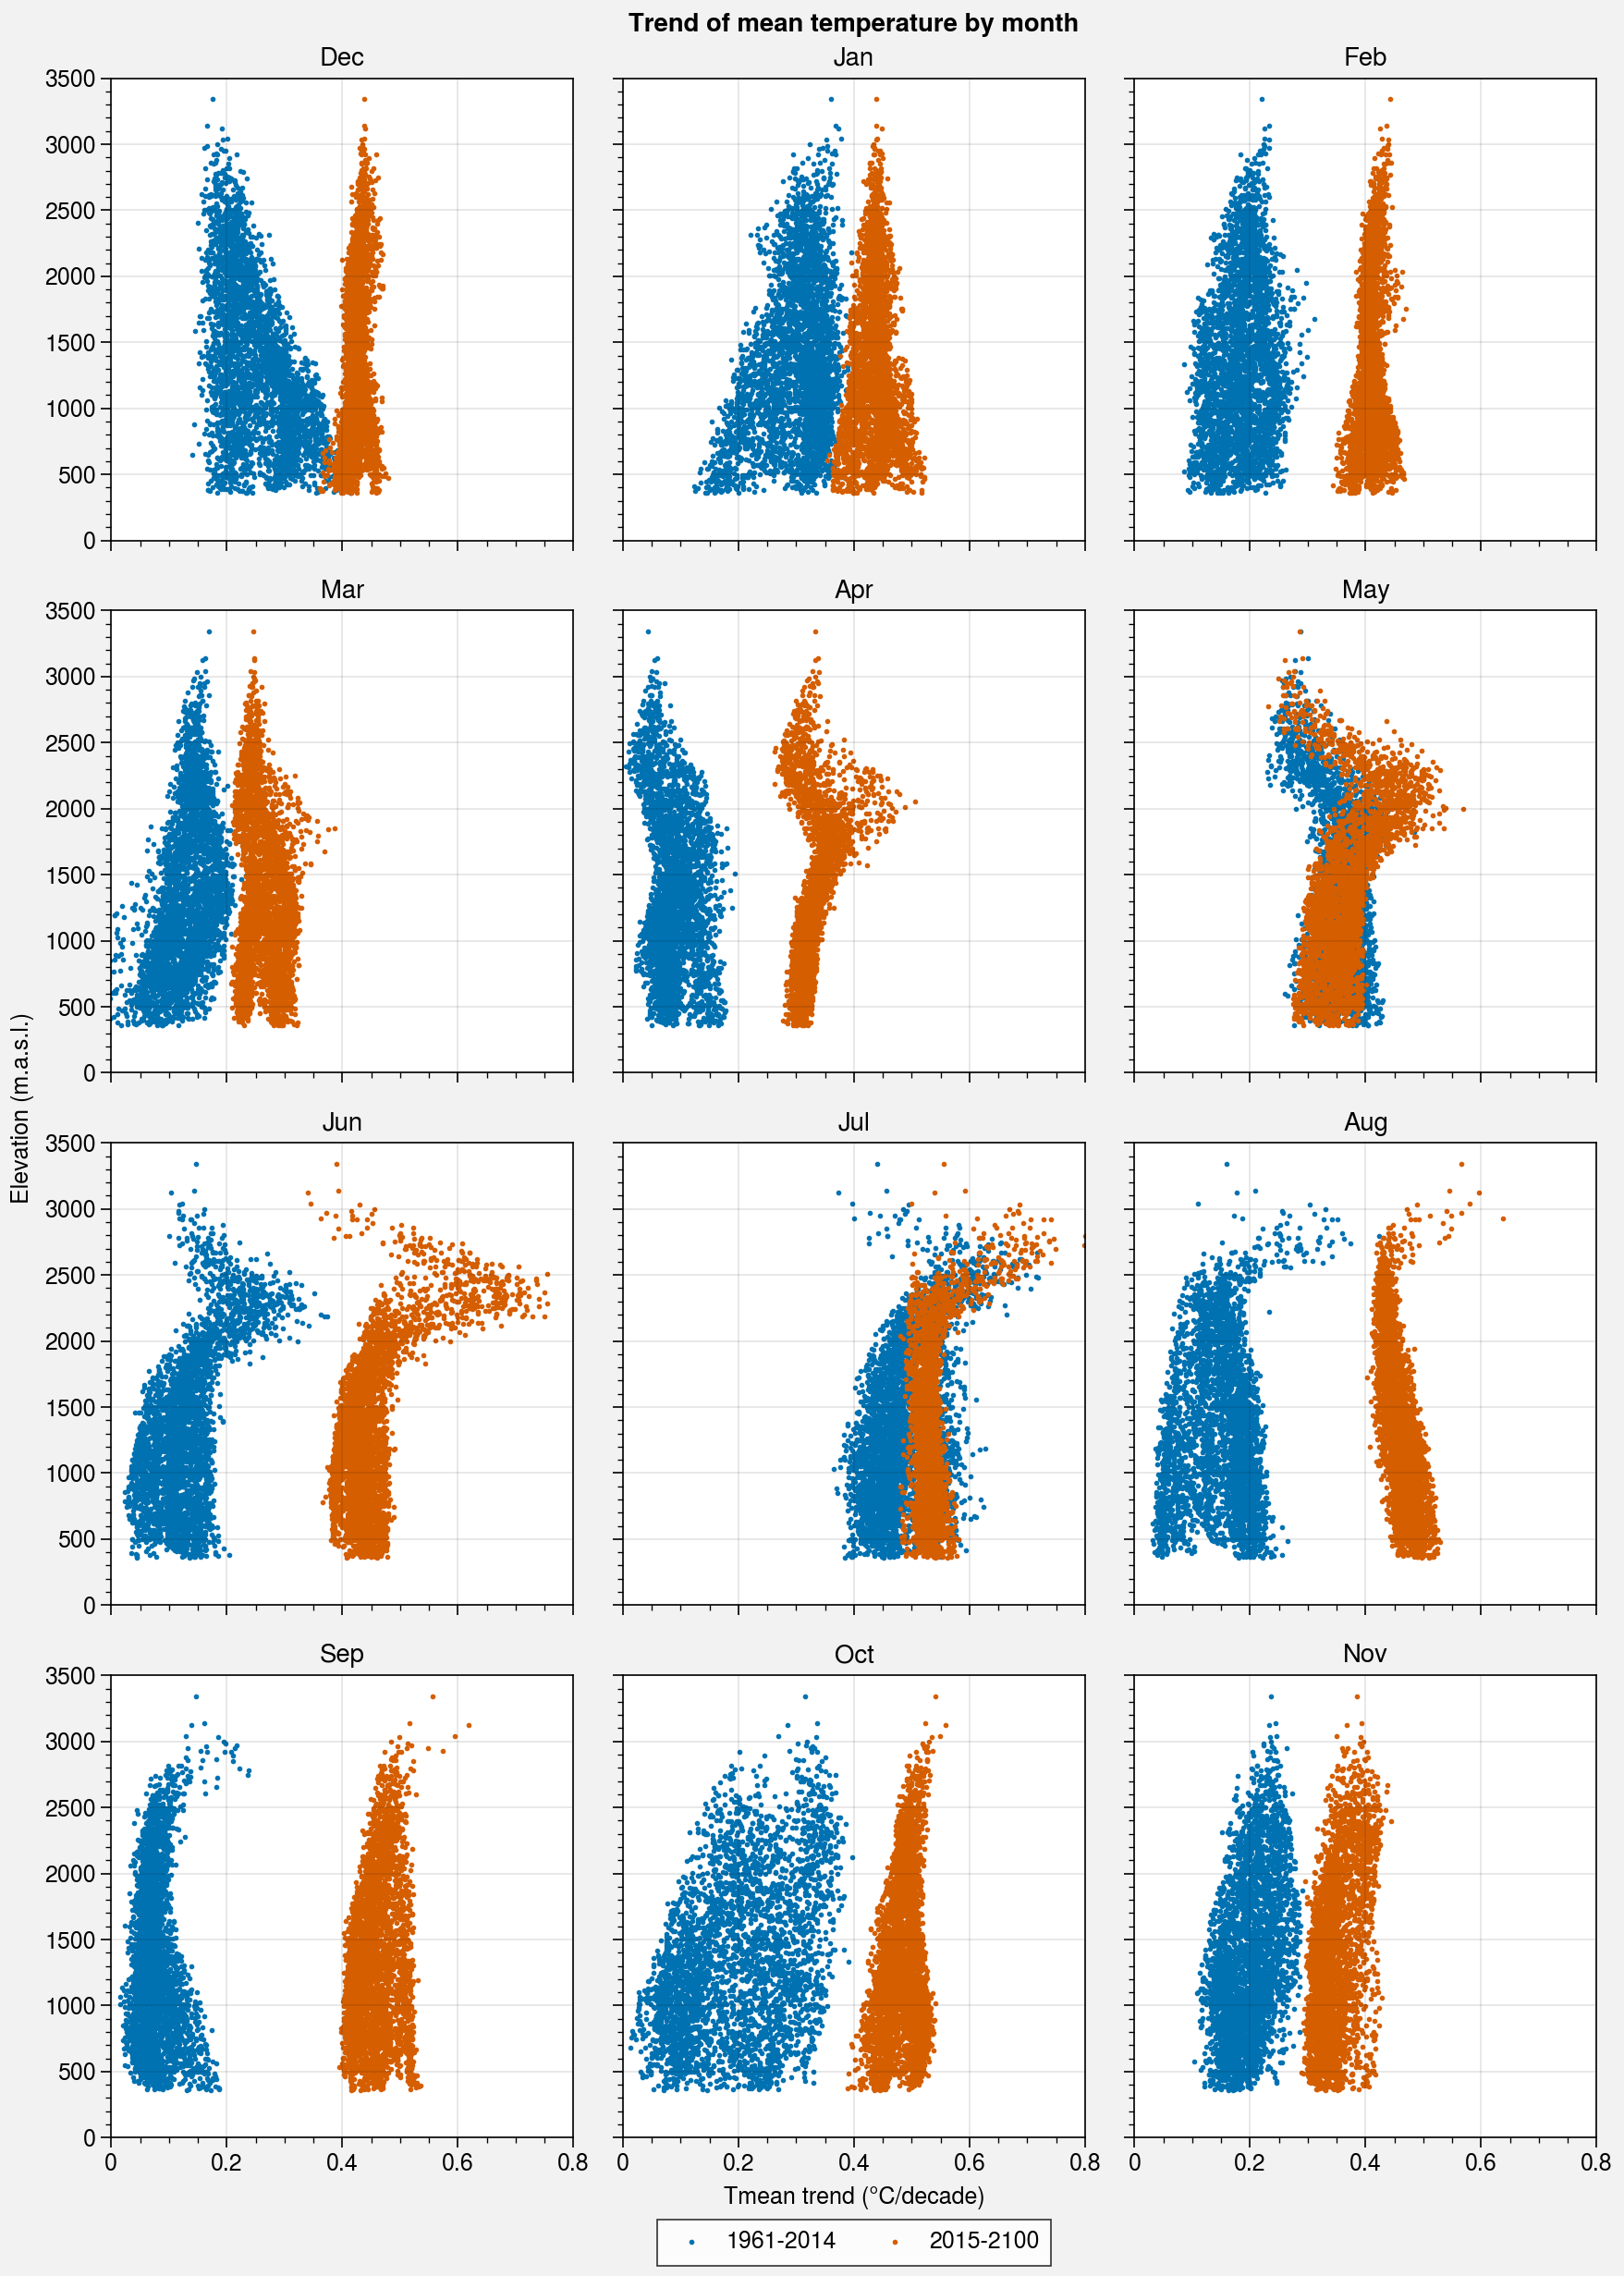

In [8]:
f, axs = pplt.subplots(ncols=3, nrows=4)
leg = ['1961-2014','2015-2100']

idx = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']

slope_T_hist_reorder = slope_T_hist[idx]
slope_T_fut_reorder = slope_T_fut[idx]


for i in range(12):
    slope_T_hist_alps = np.ma.masked_array(slope_T_hist_reorder[i], mask=np.invert(alps))
    #slope_T_hist_east_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(east_alps))
    #slope_T_hist_north_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(north_alps))
    #slope_T_hist_south_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(south_alps))
    #slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    ax = axs[i]
    blue_dot = ax.scatter(10*slope_T_hist_alps,ds.SH[jmin:jmax,imin:imax],s=2)



for i in range(12):
    slope_T_fut_alps = np.ma.masked_array(slope_T_fut_reorder[i], mask=np.invert(alps))
    #slope_T_fut_east_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(east_alps))
    #slope_T_fut_north_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(north_alps))
    #slope_T_fut_south_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(south_alps))
    #slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]

    ax = axs[i]
    orange_dot = ax.scatter(10*slope_T_fut_alps,ds.SH[jmin:jmax,imin:imax],s=2)
    ax.set_xlim((0.,0.8))
    ax.set_ylim((0.,3500))
    ax.format(title=months[i])
    if(i==10):
        ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by month',#collabels=['DJF','MAM','JJA', 'SON'],rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],
           xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

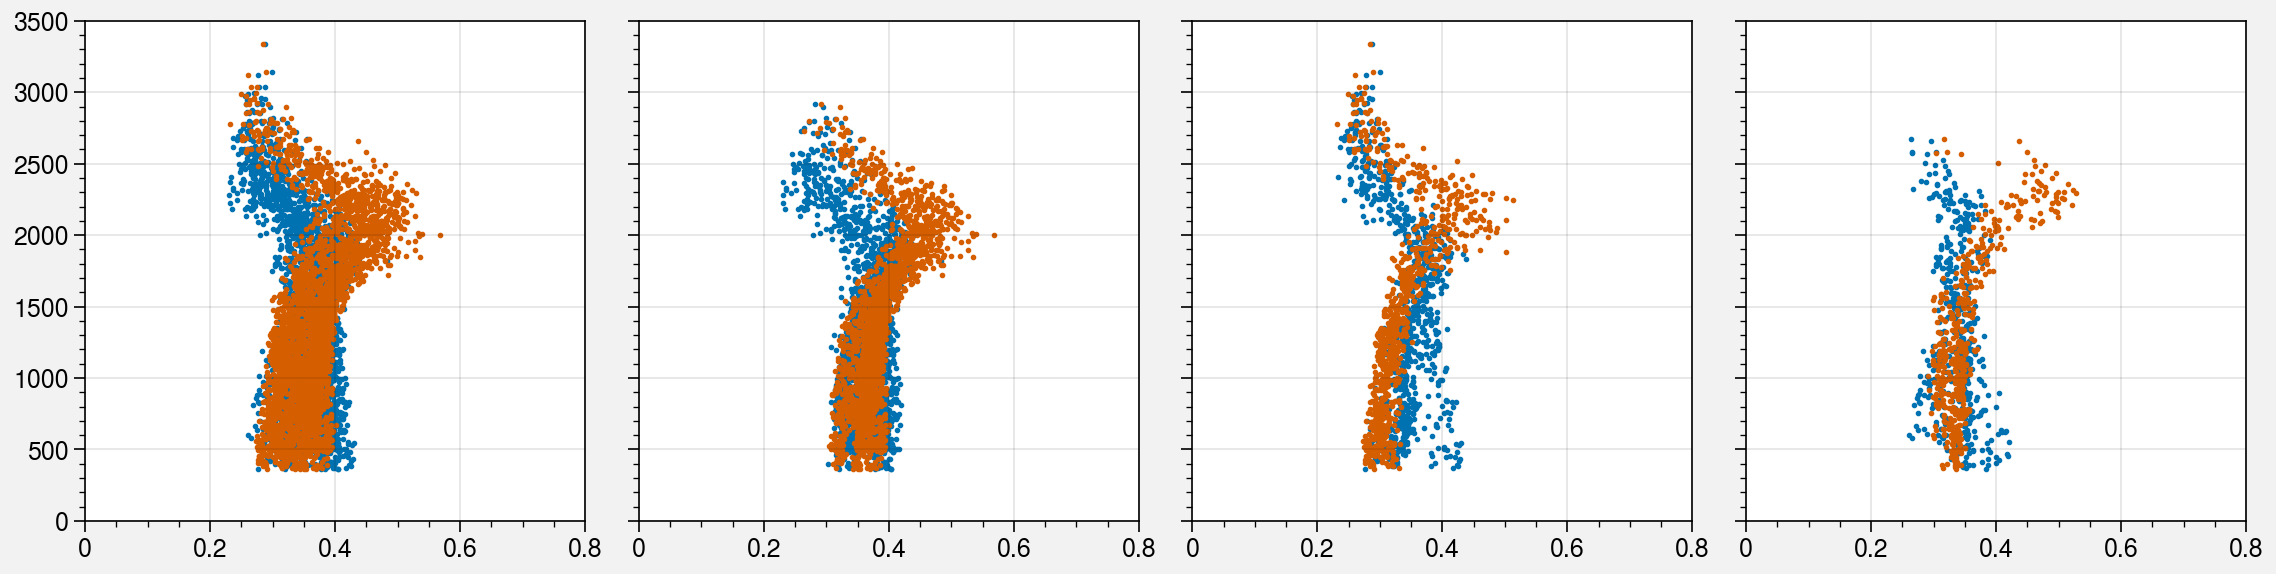

In [11]:
f, axs = pplt.subplots(ncols=4)
leg = ['1961-2014','2015-2100']

i=5

slope_T_hist_alps = np.ma.masked_array(slope_T_hist_reorder[i], mask=np.invert(alps))
slope_T_hist_east_alps = np.ma.masked_array(slope_T_hist_reorder[i], mask=np.invert(east_alps))
slope_T_hist_north_alps = np.ma.masked_array(slope_T_hist_reorder[i], mask=np.invert(north_alps))
slope_T_hist_south_alps = np.ma.masked_array(slope_T_hist_reorder[i], mask=np.invert(south_alps))
slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]

for j,slope in enumerate(slopes):
    ax = axs[j]
    blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)

slope_T_fut_alps = np.ma.masked_array(slope_T_fut_reorder[i], mask=np.invert(alps))
slope_T_fut_east_alps = np.ma.masked_array(slope_T_fut_reorder[i], mask=np.invert(east_alps))
slope_T_fut_north_alps = np.ma.masked_array(slope_T_fut_reorder[i], mask=np.invert(north_alps))
slope_T_fut_south_alps = np.ma.masked_array(slope_T_fut_reorder[i], mask=np.invert(south_alps))
slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]

for j,slope in enumerate(slopes):
    ax = axs[j]
    orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
    ax.set_xlim((0.,0.8))
    ax.set_ylim((0.,3500))

In [72]:
alps_months = np.repeat(alps[np.newaxis,:,:],12,axis=0)
alps_wp = np.repeat(alps_months[np.newaxis,:,:,:],140,axis=0)
april = 3
may = 4
june = 5
july = 6

years_hist = np.arange(1961,2015)
years_hist = years_hist.reshape(-1,1)
years_fut = np.arange(2015,2101)
years_fut = years_fut.reshape(-1,1)

T_alps = np.ma.masked_array(T_month,mask=np.invert(alps_wp))

T_alps.shape

(140, 12, 91, 139)

In [73]:
slope_T_hist.shape

(12, 91, 139)

In [74]:


slope_T_hist_alps = np.ma.masked_array(slope_T_hist,mask=np.invert(alps_months))
origin_T_hist_alps = np.ma.masked_array(origin_T_hist,mask=np.invert(alps_months))
linregress_T_hist_alps = origin_T_hist_alps.mean(axis=(1,2))+slope_T_hist_alps.mean(axis=(1,2))*(years_hist-1961)

slope_T_fut_alps = np.ma.masked_array(slope_T_fut,mask=np.invert(alps_months))
origin_T_fut_alps = np.ma.masked_array(origin_T_fut,mask=np.invert(alps_months))
linregress_T_fut_alps = origin_T_fut_alps.mean(axis=(1,2))+slope_T_fut_alps.mean(axis=(1,2))*(years_fut-2015)

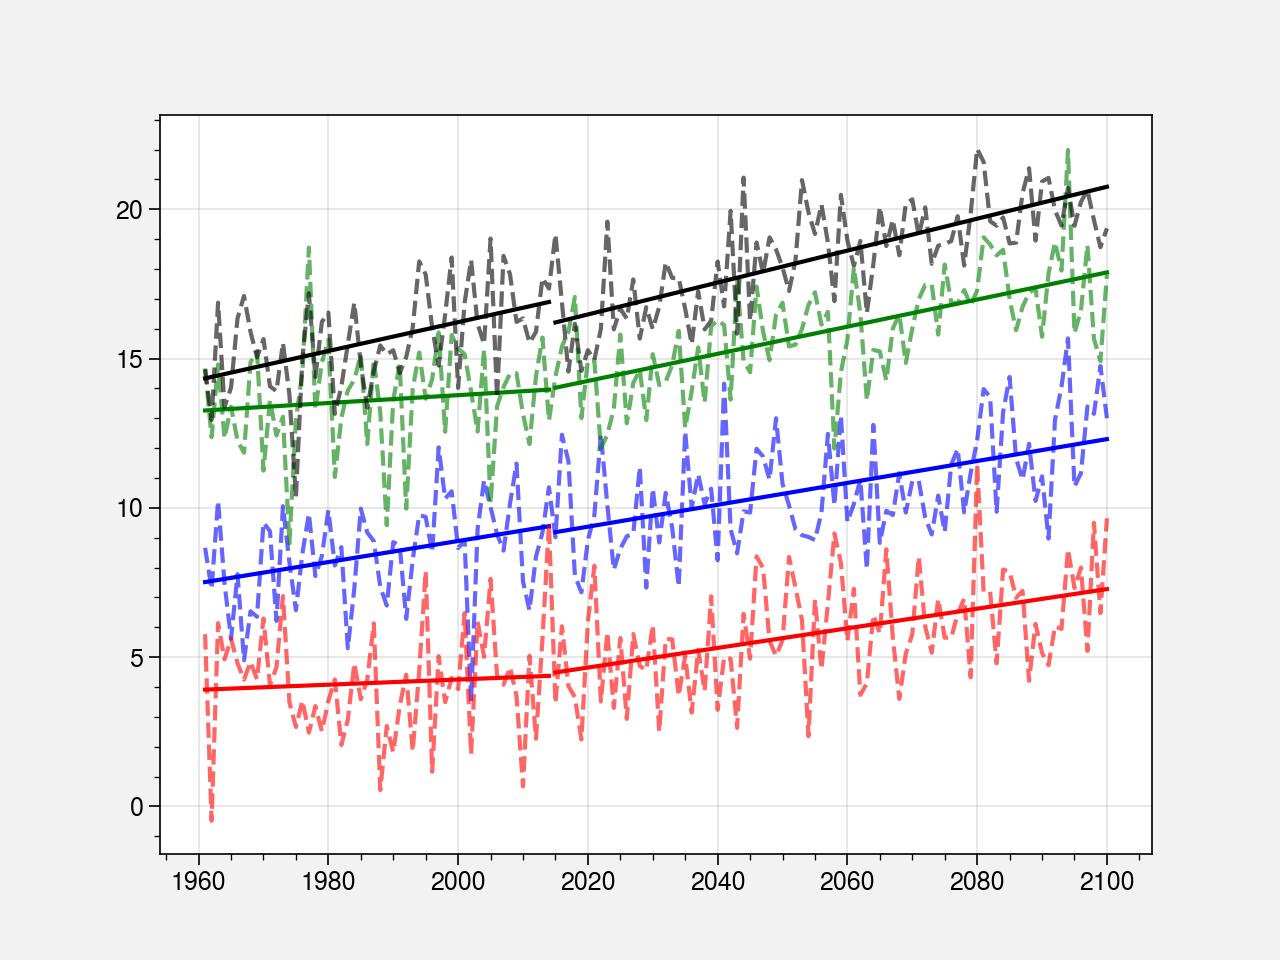

In [82]:
plt.plot(range(first_year,last_year+1),T_alps[:,may].mean(axis=(1,2)),linestyle='--',color='b',alpha=0.6)
plt.plot(years_hist,linregress_T_hist_alps[:,may],color='b')
plt.plot(years_fut,linregress_T_fut_alps[:,may],color='b')

plt.plot(range(first_year,last_year+1),T_alps[:,april].mean(axis=(1,2)),linestyle='--',color='r',alpha=0.6)
plt.plot(years_hist,linregress_T_hist_alps[:,april],color='r')
plt.plot(years_fut,linregress_T_fut_alps[:,april],color='r')

plt.plot(range(first_year,last_year+1),T_alps[:,june].mean(axis=(1,2)),linestyle='--',color='g',alpha=0.6)
plt.plot(years_hist,linregress_T_hist_alps[:,june],color='g')
plt.plot(years_fut,linregress_T_fut_alps[:,june],color='g')

plt.plot(range(first_year,last_year+1),T_alps[:,july].mean(axis=(1,2)),linestyle='--',color='k',alpha=0.6)
plt.plot(years_hist,linregress_T_hist_alps[:,july],color='k')
plt.plot(years_fut,linregress_T_fut_alps[:,july],color='k')

In [94]:
viridis = plt.cm.get_cmap('viridis', 12)

cmap_vir = viridis(np.linspace(0, 1, 12))

(1960.0, 2015.0)

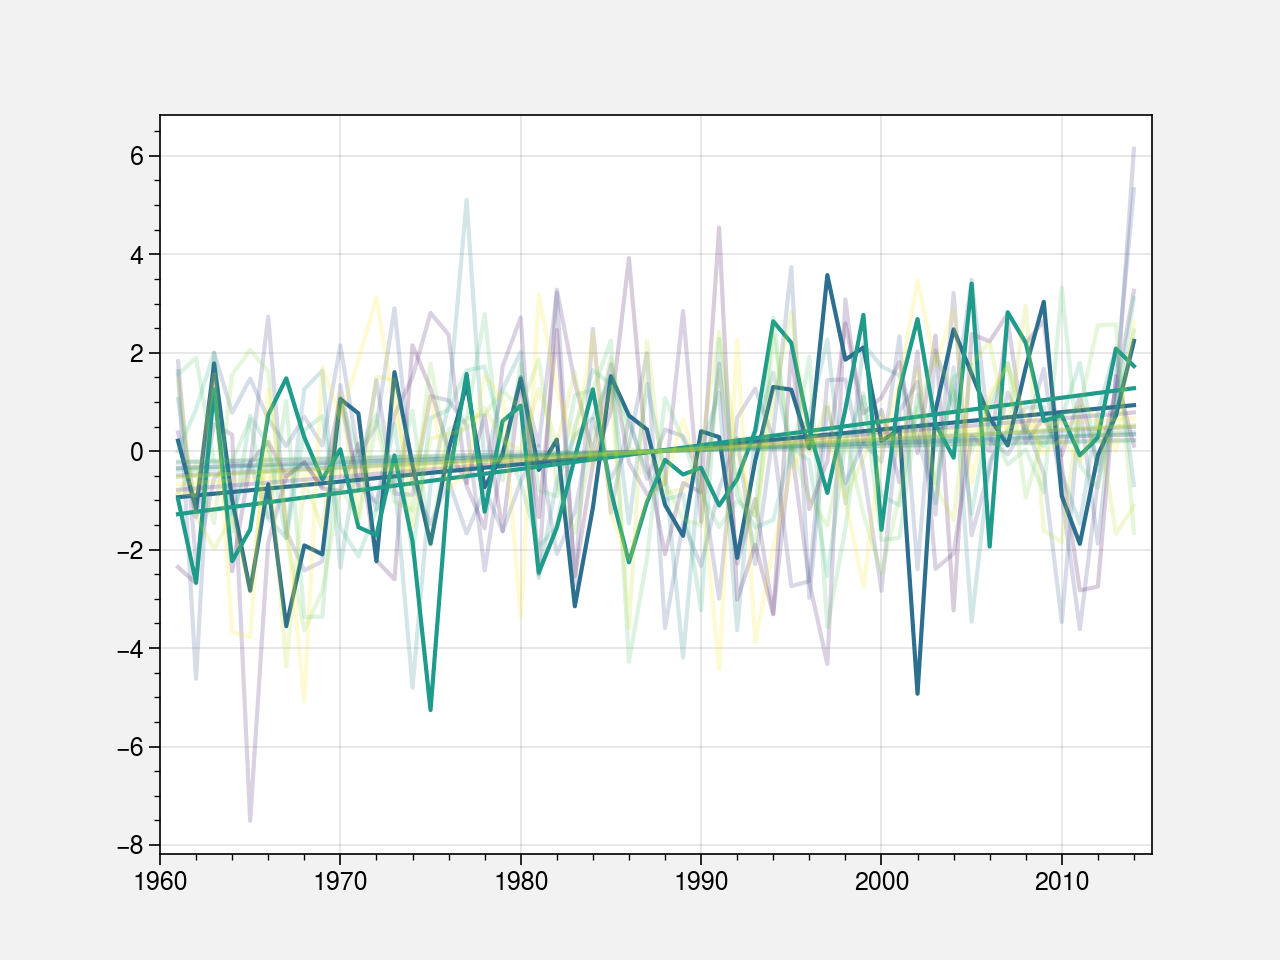

In [100]:


for i in range(12):
    if i==4 or i==6:
        plt.plot(years_hist,T_alps[:54,i].mean(axis=(1,2))-T_alps[:54,i].mean(),color=cmap_vir[i])
        plt.plot(years_hist,linregress_T_hist_alps[:,i]-linregress_T_hist_alps[:,i].mean(),color=cmap_vir[i])
    else:
        plt.plot(years_hist,T_alps[:54,i].mean(axis=(1,2))-T_alps[:54,i].mean(),alpha=0.2,color=cmap_vir[i])
        plt.plot(years_hist,linregress_T_hist_alps[:,i]-linregress_T_hist_alps[:,i].mean(),alpha=0.2,color=cmap_vir[i])
plt.xlim(1960,2015)

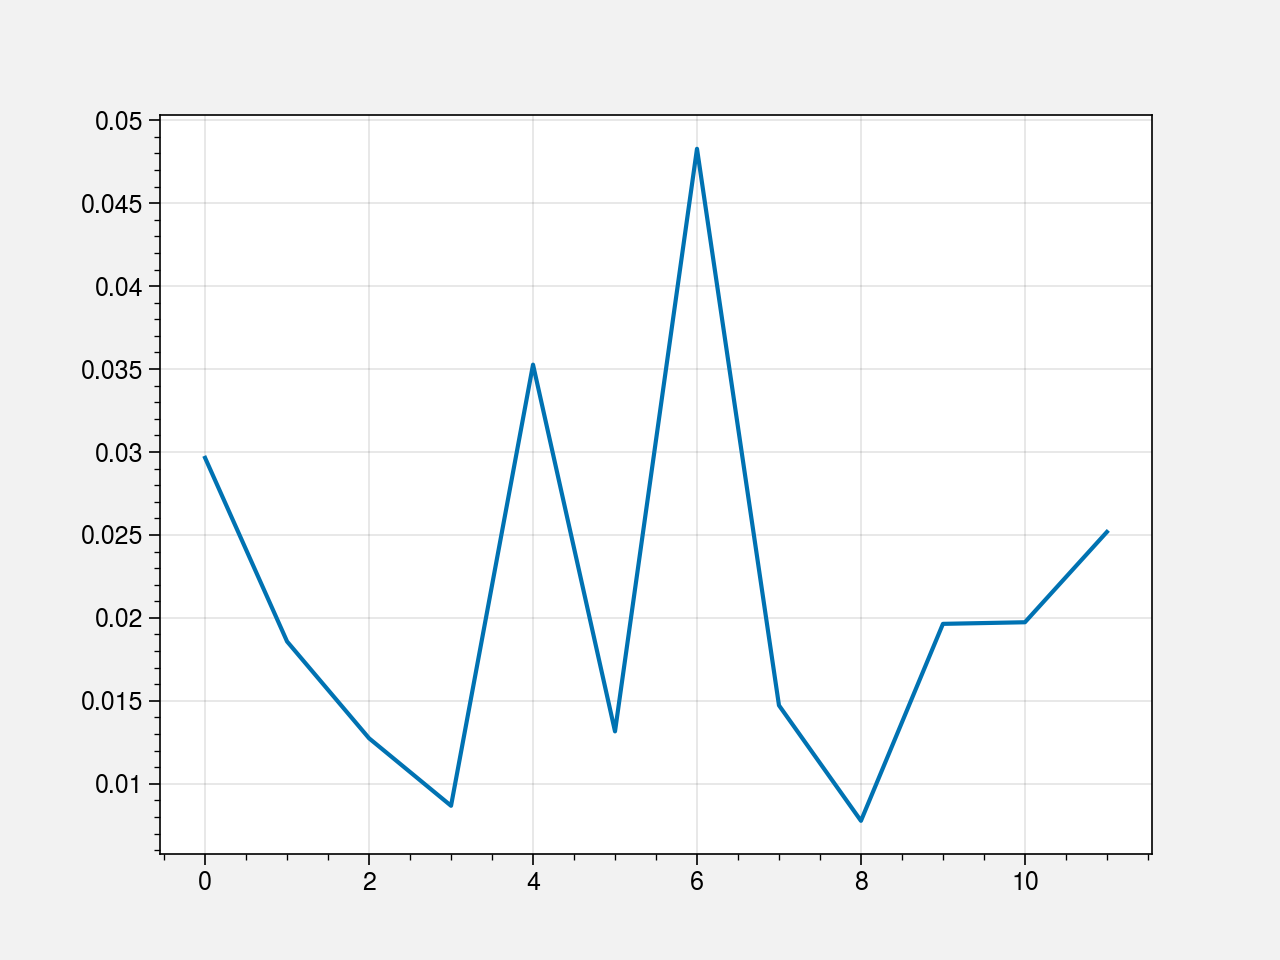

In [104]:
plt.plot(slope_T_hist_alps.mean(axis=(1,2)))